In [11]:
# Imports & setup for the code throughout the document to work

import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
from helpers import cfsToM3s, m3ToKm3

# In descending order for legend order
panel_areas = [600000000, 400000000, 200000000, 100000000, 50000000, 25000000, 10000000, 1000000, 100000, 0] # m^2
overall_costs = []

MAX_AREA = 640000000  # m^2
MAX_VOLUME = 32.24 * 1000000000  # m^3
MAX_HEIGHT = 100  # meters
LENGTH = 10000 # meters
MAX_BASE = 64000 # meters
ANGLE = 89.82 # 
STARTING_VOLUME = 32 * 1000000000  # starting volume of lake mead. m^3

V_in = cfsToM3s(11800)  # m^3 / s
V_dam = cfsToM3s(10083.3102)  # m^3 / s

# Background
The Colorado River, which starts in the Rocky Mountains, flows through Lake Mead and the Hoover dam. It passes through seven US states as well as multiple national parks and tribe grounds where it is the primary water source for millions of people [1]. Lake Mead has currently, largely due to the effect of twenty years of drought, been experiencing a massive water shortage [1]. The level of the lake has dropped approximately 200 feet in the past twenty years to 1041 feet deep; in order for Hoover Dam to successfully run, the level must be maintained above 1000 feet, which is currently extremely close [2]. A large contributer of this loss of water comes from drought over the past few years, which has led to less rainfall overall and greater evaporation rates from Lake Mead itself. 

### Question
*How cost-effective is it to use solar panels to simultaneously prevent evaporation of Lake Mead and generate more electricity?*

The proposed solution to the Lake Mead water crisis being investigated here is floatovoltaics, or solar panels that would float on the surface of the lake. 

The goal of this project is to compare the ratio of effectiveness at preventing evaporation to the cost of the square footage of solar panels used, which would allow us to determine how many panels it is worth putting time and money into making to minimize the ongoing water crisis.

# Modeling

### Schematic

![Flow of water in and out of Lake Mead](schematic3.png)
Flow of the water in and out of Lake Mead. Water comes in from the Colorado River and leaves through evaporation and through the Hoover Dam outflow.

### Equations & Important Values

#### Volume of Water Based on Evaporation Rate
$V_h = \frac{Θ(x_s - x)A}{density}$

Where:
* $g_h$ = amount of evaporated water per hour (kg/h)
* $Θ$ = (25 + 19 v) = evaporation coefficient (kg/m2h)
* $v$ = velocity of air above the water surface (m/s)
* $A$ = water surface area (m^2)
* $x_s$ = maximum humidity ratio of saturated air at the same temperature as the water surface (kg/kg)  (kg H2O in kg Dry Air)
* $x$ = humidity ratio air (kg/kg) (kg H2O in kg Dry Air)
* $\rho$ = density of water\
The equation is divided by density of water in order to get the volume per hour as that is what is used in the model's first order ODE calculations.

#### Humidity Ratios for Evaporation Equation
$x = \frac {m_w}{m_a}$

Where:
* $x$ = Humidity ratio
* $m_w$ = Mass of water vapor in the air (g)
* $m_a$ = Mass of dry air (g)

The humidity ratio is based on the temperature of the air and the range of air temperatures for Lake Mead was determined to be 9.6 - 35.4 °C, which was simplified to 22.5 °C by taking the average of those two values [3], [4].

The plot in the Engineering Toolbox displays the maximum humidity ratio $x_s$. for 22.5 °C. Unfortunately there is no equation for this listed, so the ratio was approximated from the graph to be about 0.017 [3].

Finding $x$, or the regular humidity ratio: 
This value varies sometimes as frequently as hour by hour; however, for the sake of simplicity and modeling over a long period of time, a single value was used as opposed to representing this as an equation. This value was determined by using the psychometric chart to find the relationship between relative humidity and air temperature.

The singular value for humidity chosen here was the average relative humidity adn dry bulb temperature for the month of July as that is the hottest month for Lake Mead and presumably when the greatest amount of evaporation occurs.

The average humidity in July was 21%. The temperature ranged from 83 to 100 degrees Fahrenheit, which averages to 91.5 degrees, which corresponds to 45 grains of moisture per pound of dry air for the humidity ratio based on the psychometric chart [5]. The final humidity ratio was then calculated: $\frac{45}{7000} = 0.00642857143$, as there are 7000 grains in one pound [6].

#### Solar Panels & Cost Efficiency
$C_w = wpc$

Where:
* $C_w$ = Cost of water in Lake Mead (\$)
* $w$ = Water used per day per person (m^3)\
$w$ was determined to be 90 gallons, or 0.340687 m^3 water used per day by a single person [7]
* $p$ = Number of people who get water from Lake Mead\
$p$ was determined to be approximately 25 million people [1].
* $c$ = Cost of each cubic meter of water ($\$ / m^3$)
$c$ was calculated by taking the average of the cost of water bills in the states that receive water from Lake Mead - California (\\$77), Arizona (\\$64), Colorado (\\$39), Utah(\\$38), New Mexico(\\$32), Nevada(\\$26), and Wyoming (\\$53) - averaging to \\$47 dollars per month, or \\$1.51612903 dollars per day. Based on $w$, each cubic meter of water is determined to be \\$4.45021099 [8], [9]

The cost of solar panels per square meter was determined by taking the average of a range of typical solar panel costs, giving \\$75 per square meter of panel [10]. 

400W solar panels are typically 72-cell, which is 3.25 feet by 6.42 feet [11]. 3.25 feet by 6.42 feet = 20.865 ft^2 = 1.93842193 m^2. 1.93842193 m^2 of solar panels produces 1.8 kWatt-hours per day [12]. Therefore, 1 square meter of panels produces 0.92859 kwh per day. We need units of Watt-hours per second, because the linear space for the ODE is every second. 0.92859 / 3600 = 0.000257941667 kwh/s. Each square meter produces 0.000257941667 kwh per second.

Electricity costs in cents per kwh for California, Arizona, Colorado, Utah, New Mexico, Nevada and Wyoming are 24.19, 11.98, 12.51, 9.43, 11.31, 11.58, 8.51 respectively [13]. The average of these values is: 89.51/7 = 12.7871428571 cents / kwh whcih can be used to find the price of how much energy one square meter of panels can generate: 12.7871428571 cents / kwh * 0.000257941667 kwh / s = 0.00329833694 cents per second, for one square meter.

These units are then converted to seconds - (12.7871428571 cents / kwh) * (1 kwh / 3600 kws) * (1 kws / 1000 w/s) = 0.00000355198413 cents/W-s = 0.0000000355198413 dollars per W/s - giving the average value of electricity. The amount of total revenue one square meter of panels generates from the electricity it produces can then be calculated:0.0000000355198413 $/(W/s) * 0.257941667 (W/s) / m^2 = 9.16204708 * 10^-9 $/m^2.

### Assumptions
When developing this model, we made a few key assumptions & acknowledged that certain factors are outside of our control:
1. The only input to the system in the model is water from the Colorado River; in reality, 97% of the water flowing into Lake Mead comes from the Colorado River and we determined that the remaining 3% of other sources would have little to no impact in the long run and was not worth modeling.
2. The flow rate used was taken from Diamond Creek due to its close proximity to Lake Mead.
3. The shape of the lake was represented as an inverted triangluar prism; this ensures that the surface area of the lake changes based on the height of the water, which is affected by the evaporation rate.

The code for the model based on the above equations and assumptions can be seen below:

In [12]:
def model(V, t, V_in, V_dam, panel_area):
    '''
    Insert docstrings here
    '''
    DENSITY = 1000  # Density of water (kg/m^3)

    # maximum humidity ratio of saturated air at the same temperature as the water surface (kg/kg)  (kg H2O in kg Dry Air)
    MAX_HUM_RATIO = 0.030
    HUM_RATIO = 0.015  # humidity ratio air (kg/kg) (kg H2O in kg Dry Air)

    area = 2*V / math.sqrt(V/(LENGTH*math.tan(math.radians(ANGLE))))

    v_air = 7  # m/s

    # kg / (m^2 * h)
    Theta = 25+(19*v_air)			# v_air = velocity of air

    # this will be a function of surface area, which we can calculate from V/h
    V_evap = Theta*(area-panel_area)*(MAX_HUM_RATIO - HUM_RATIO) / (DENSITY * 3600)
    
    dVdt = V_in - V_dam - V_evap
    return dVdt

# Validation
Lake Mead's water flow over the course of ten years with input from the Colorado River and outflow being the Hoover Dam release and evaporation was modeled as a baseline [14-16].

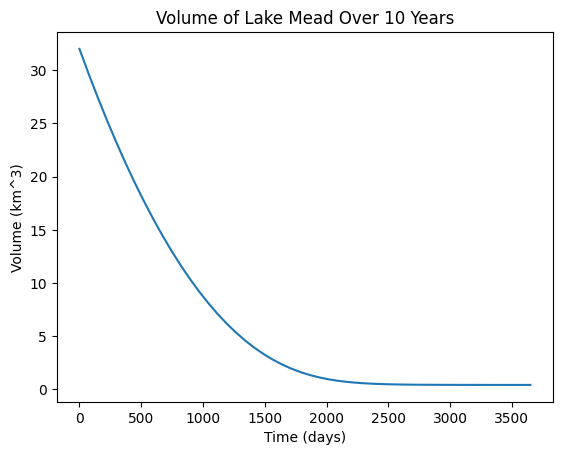

In [13]:

# represent the model time as seconds in a year
t = np.linspace(0, 31536000*10)

fig, a = plt.subplots()
result = odeint(model, STARTING_VOLUME, t, args=(V_in, V_dam, 0)) # Sets solar panel area to 0
a.plot(t/86400, m3ToKm3(result))

a.set_title('Volume of Lake Mead Over 10 Years')
a.set_xlabel('Time (days)')
a.set_ylabel('Volume (km^3)')

plt.show()

# Results & Discussion
The implementation of the project has two sections - the MVP and a cost effectiveness analysis

### MVP 
The effect of varying solar panel size was determined by performing a sweep of square footage of Lake Mead covered in solar panels over a ten year period and plotting that with the baseline model.

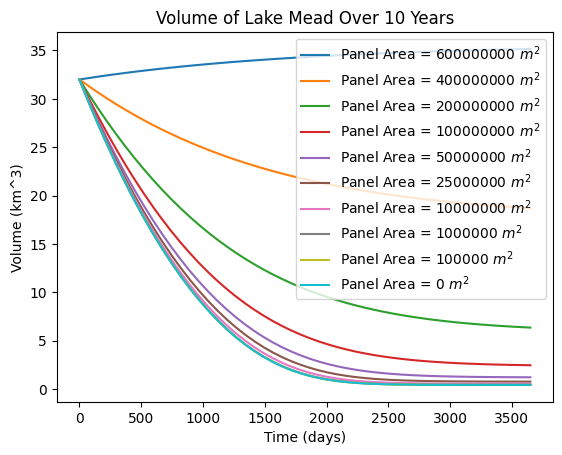

In [14]:
# MVP Plots

result = []

# represent the model time as seconds in a year
t = np.linspace(0, 31536000*10)

fig, ax = plt.subplots()

for i, panel_area in enumerate(panel_areas):
    result.append(odeint(model, STARTING_VOLUME, t, args=(V_in, V_dam, panel_area)))
    ax.plot(t/86400, m3ToKm3(result[i]), label=f'Panel Area = {panel_area} '+r'$m^2$')

ax.set_title('Volume of Lake Mead Over 10 Years')
ax.legend()
ax.set_xlabel('Time (days)')
ax.set_ylabel('Volume (km^3)')

plt.show()

This iteration of the model proves that floatovoltaics is a potential solution to the Lake Mead water crisis as there is a clear correlation between an increase in the area of the solar panels covering Lake Mead and a decrease in the amount of water lost by Lake Mead over the course of ten years.

### Cost Effectiveness Analsysis
The next iteration of the model determines the cost-effectiveness of various solar panel size solutions. The cost was calculated by taking the difference between the initial cost to purchase solar panels and the panel electicity production value and adding that to the total volume of the water. 

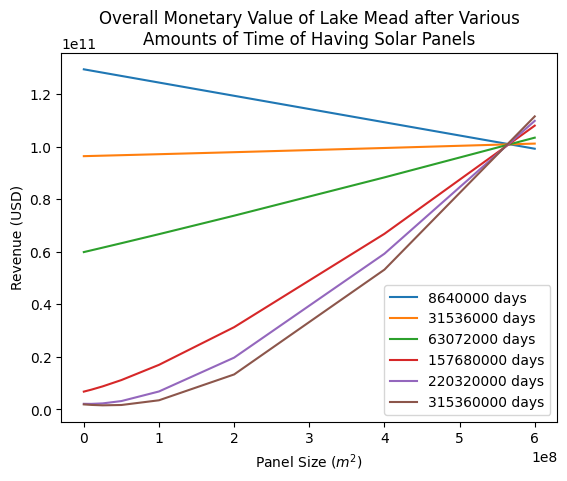

In [16]:
# Iteration 1 plots

def costs(V, t, V_in, V_dam, panel_area):
    '''
    Insert docstrings here
    '''
    DENSITY = 1000  # Density of water (kg/m^3)

    # maximum humidity ratio of saturated air at the same temperature as the water surface (kg/kg)  (kg H2O in kg Dry Air)
    MAX_HUM_RATIO = 0.030
    HUM_RATIO = 0.015  # humidity ratio air (kg/kg) (kg H2O in kg Dry Air)

    area = 2*V / math.sqrt(V/(LENGTH*math.tan(math.radians(ANGLE))))

    v_air = 7  # m/s

    # kg / (m^2 * h)
    Theta = 25+(19*v_air)			# v_air = velocity of air

    # this will be a function of surface area, which we can calculate from V/h
    V_evap = Theta*(area-panel_area)*(MAX_HUM_RATIO - HUM_RATIO) / (DENSITY * 3600)

    dVdt = V_in - V_dam - V_evap

    return dVdt


PANEL_COST = 75  # dollar cost per square meter
WATER_COST = 4.45  # dollar cost per cubic meter of water
ELECTRICITY_COST = 0.127871428571  # dollar price of electricity per kWh
PANEL_KWATTS_PER_SECOND = 0.000257941667  # kWh/s for one square meter of panel

times = [86400*100, 86400*365, 86400*365*2, 86400*365*5, 86400*2550, 86400*365*10]  # seconds

V_in = cfsToM3s(11800)  # m^3 / s
V_dam = cfsToM3s(10083.3102)  # m^3 / s
V_0 = MAX_VOLUME  # m^3

plt.figure(1)
for time in times:
    cost_values = []
    for panel_area in panel_areas:
        t = np.linspace(0, time)
        volume = odeint(costs, V_0, t, args=(V_in, V_dam, panel_area))[-1][0]
        panel_electricity_price = PANEL_KWATTS_PER_SECOND*ELECTRICITY_COST*panel_area  # total dollar price of electricity for 1 second
        cost = panel_electricity_price - panel_area*PANEL_COST + volume*WATER_COST
        cost_values.append(cost)
    plt.plot(panel_areas, cost_values, label = f'{time} days')


plt.legend()
plt.title('Overall Monetary Value of Lake Mead after Various\nAmounts of Time of Having Solar Panels')
plt.xlabel('Panel Size (' + r'$m^2$' + ')')
plt.ylabel('Revenue (USD)')

plt.show()

This graph plots the overall possible revenue from various sizes of panels. There are multiple curves, representing different amounts of time. They all intersect at one point on the graph, at around 5.64 * 10^8 square meters of panel. This is the amount of solar panels that would make Lake Mead stay at an equilibrium within our model; the inflow from the Colorado River is exactly the same as the combined evaporation and Hoover Dam release outflows.

For panel sizes less than around 5.64 * 10^8 square meters (basically everything to the left of this equilibrium intersection point), the plots demonstrate that over time, the cost efficiency goes down. This is *not* what we want; we want to be gaining money! So we must look to all points on the right of the intersection point. For these sizes of solar panels, the "revenue" actually goes up over time (the points at 3650 days are greater than the points at 100 days).

Overall, this plot indicates that covering Lake Mead with more solar panels is more cost effective than having less solar panels. The ideal is to have coverage for more than 5.64 * 10^8 square meters of the lake, because this is when the cost efficiency becomes positive over time. Furthermore, it is also the point where Lake Mead's outflow becomes less than its inflow, meaning that the lake will not dry up over time.

# References
[1]&nbsp;S. McGovern, "Lake Mead and Colorado River Basin Water Shortage: Causes, Effects, and Policy Solutions", *Earth.Org*, 2022. [Online]. Available: https://earth.org/lake-mead-and-colorado-river-basin-water-shortage/#:~:text=Formal%20Water%20Shortage%20Declared%20for,of%20natural%20and%20anthropogenic%20activities. [Accessed: 17- Oct- 2022].

[2]&nbsp;W. Choi-Schagrin, "See How Far Water Levels in Lake Mead Have Fallen", *NYTimes*, 2022. [Online]. Available: https://www.nytimes.com/2022/07/22/climate/lake-mead-level-pictures.html#:~:text=Lake%20Mead%2C%20the%20largest%20reservoir,the%20country's%20largest%20agricultural%20valleys. [Accessed: 17- Oct- 2022].

[3]&nbsp;Engineering ToolBox, "Air - Humidity Ratio", *Engineering Toolbox*, 2004, [Online]. Available: https://www.engineeringtoolbox.com/humidity-ratio-air-d_686.html [Accessed: 17- Oct- 2022].

[4]&nbsp;"Lake Mead Water Temperature: Forecasts & current water temp", *Watertemperature.net*, 2022. [Online]. Available: https://www.watertemperature.net/united-states/lake-mead-water-temperature.html. [Accessed: 17- Oct- 2022].

[5]&nbsp;F. WeatherWX.com, "Lake Mead AZ Climate Averages, Monthly Weather Conditions", *WeatherWX.com*, 2022. [Online]. Available: https://www.weatherwx.com/climate-averages/az/lake+mead.html. [Accessed: 17- Oct- 2022].

[6]&nbsp;Engineering Toolbox, "Psychometric Chart", *Engineering Toolbox*, [Online]. Available https://www.engineeringtoolbox.com/docs/documents/816/psychrometric_chart_29inHg.pdf. [Accessed: 17- Oct- 2022].

[7]&nbsp;"Water Q&A: How much water do I use at home each day? | U.S. Geological Survey", *USGS*, 2019. [Online]. Available: https://www.usgs.gov/special-topics/water-science-school/science/water-qa-how-much-water-do-i-use-home-each-day. [Accessed: 17- Oct- 2022].

[8]&nbsp;L. Runyon, "On the Colorado River the feds carry a big stick. Will the states get hit?", KUNC, 2022. [Online]. Available: https://www.kunc.org/environment/2022-07-19/on-the-colorado-river-the-feds-carry-a-big-stick-will-the-states-get-hit#:~:text=That%20infrastructure%20includes%20the%20Colorado,New%20Mexico%2C%20Nevada%20and%20Wyoming. [Accessed: 17- Oct- 2022].

[9]&nbsp;"Water Prices by State 2022", *WorldPopulationReview*, 2022. [Online]. Available: https://worldpopulationreview.com/state-rankings/water-prices-by-state. [Accessed: 17- Oct- 2022].

[10]&nbsp;A. Donaldson, "Cost of Solar Panels Per Square Meter - Bank Breaking Beauty", Solar Power Fam. [Online]. Available: https://www.solarpowerfam.com/cost-of-solar-panels-per-square-meter/. [Accessed: 17- Oct- 2022].

[11]&nbsp;V. Aggarwal, "How much energy does a solar panel produce?", *EnergySage*, 2022. [Online]. Available: https://news.energysage.com/what-is-the-power-output-of-a-solar-panel/. [Accessed: 17- Oct- 2022].

[12]&nbsp;A. USA, "Solar Panel Dimensions and Sizes: Complete Guide - Airis Energy", *Airis Energy*. [Online]. Available: https://airisenergy.us/solar-panels-dimensions/#:~:text=The%20average%2072%2Dcell%20solar,60%2Dcell%20standard%20size%20panels. [Accessed: 17- Oct- 2022].

[13]&nbsp;"Electric Power Monthly - U.S. Energy Information Administration (EIA)", *EIA*, 2022. [Online]. Available: https://www.eia.gov/electricity/monthly/epm_table_grapher.php?t=epmt_5_6_a. [Accessed: 17- Oct- 2022].

[14]&nbsp;"Monitoring the River - Lake Mead National Recreation Area (U.S. National Park Service)", *NPS*, 2017. [Online]. Available: https://www.nps.gov/lake/learn/monitoring-the-river.htm. [Accessed: 17- Oct- 2022].

[15]&nbsp;*USBR*, 2022. [Online]. Available: https://www.usbr.gov/lc/region/g4000/hoover.pdf. [Accessed: 17- Oct- 2022].

[16]&nbsp;*USBR*, 2022. [Online]. Available: https://www.usbr.gov/lc/region/g4000/24mo.pdf. [Accessed: 17- Oct- 2022].